In [2]:
# 最新のCOVID-19のデータをWikiから（厚労省のデータ一覧）取得
from urllib import request
from bs4 import BeautifulSoup
response = request.urlopen('https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Japan')
soup = BeautifulSoup(response)
response.close()

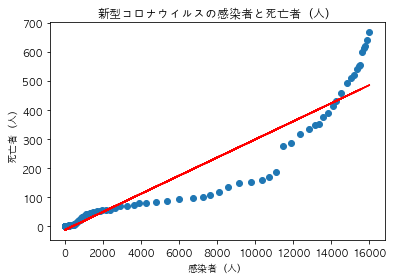

データ乖離=59.78923634187303
学習用データの説明変数が目的変数に合致する率=0.9195646985236091
テストデータの説明変数が目的変数に合致する率=0.8923853332143273


In [120]:
# WikipediaデータからCOVID-19のデータを取得
import re
import pandas as pd
EXTRACT_DIGITS = lambda string: re.search(r'[\d,]+', string)
def wikipedia2covid19():
    data = []
    for rows in soup.find('div', class_='barbox tright').select('table')[0].select('tbody')[0].select('tr'):
        row = rows.select('td.bb-04em')
        if len(row) == 0:
            continue
        date = row[0].text
        case = EXTRACT_DIGITS(row[1].text)
        if case != None:
            case = case.group()
        death = EXTRACT_DIGITS(row[2].text)
        if death != None:
            death = death.group()
        data.append({'date': date, 'case': case, 'death': death})
    return pd.DataFrame(data)

# データを整形する
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
AUTO_RESHAPE_DIGITS = lambda column: pd.DataFrame([0 if x == None else int(x.replace(',', '')) for x in column.values]).values.reshape(-1, 1)
def plot_scatter_covid19(df, lr, test_size=0.4):
    case = AUTO_RESHAPE_DIGITS(df.case)
    death = AUTO_RESHAPE_DIGITS(df.death)
    X_train, X_test, y_train, y_test = train_test_split(case, death, test_size=test_size, random_state=0)
    lr.fit(X_train, y_train)
    y_test_pred = lr.predict(X_test)
    plt.title('新型コロナウイルスの感染者と死亡者（人）')
    plt.scatter(case, death)
    plt.plot(X_test, y_test_pred, color='red')
    plt.xlabel('感染者（人）')
    plt.ylabel('死亡者（人）')
    plt.show()
    return pd.DataFrame({ 'X': { 'train': X_train, 'test': X_test }, 'y': { 'train': y_train, 'test': y_test, 'pred': y_test_pred } })

from math import sqrt
from sklearn.metrics import mean_squared_error
def score_rmse_r2(tts, lr):
    return pd.Series({'rmse': sqrt(mean_squared_error(tts.y.test, tts.y.pred)), 'train': lr.score(tts.X.train, tts.y.train), 'test': lr.score(tts.X.test, tts.y.test) })

lr = LinearRegression()
tts = plot_scatter_covid19(wikipedia2covid19(), lr)
score = score_rmse_r2(tts, lr)

print('データ乖離=' + str(score.rmse))
print('学習用データの説明変数が目的変数に合致する率=' + str(score.train))
print('テストデータの説明変数が目的変数に合致する率=' + str(score.test))
